#  Customer Churn Analysis Project  

###  Project Objective  
The objective of this project is to analyze customer churn behavior for a subscription-based telecom service and build a machine-learning model that can predict which customers are most likely to discontinue their service.  
This project demonstrates an end-to-end data analytics workflow — from data cleaning and feature engineering to customer segmentation, churn prediction, and actionable business recommendations.

###  Business Context  
Customer retention is one of the most critical challenges for any subscription-based business. Acquiring a new customer is typically five times more expensive than retaining an existing one.  
By identifying potential churners early, companies can implement targeted interventions to improve customer satisfaction and reduce revenue loss.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r'C:\Users\visha\OneDrive\Desktop\Data Projects\Telco Customer Churn\Data\raw\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


(7043, 21)

# Check Missing Values & Calculate Churn Rate  

###  Objective  
Identify missing or invalid data and calculate the overall churn percentage in the dataset.

In [7]:
df.isna().sum()        # check missing values


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df['Churn'].value_counts(normalize=True) * 100   # churn percentage

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

# Exploratory Data Analysis (EDA)

###  Objective  
Visualize how churn varies with key customer attributes to identify early behavioral patterns.

###  What We’ll Do  
- Plot churn distribution  
- Compare churn vs. tenure  
- Compare churn vs. monthly charges  
- Examine churn by contract type and payment method  

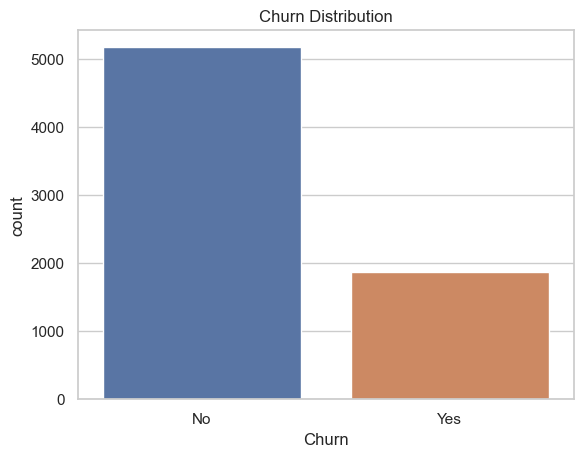

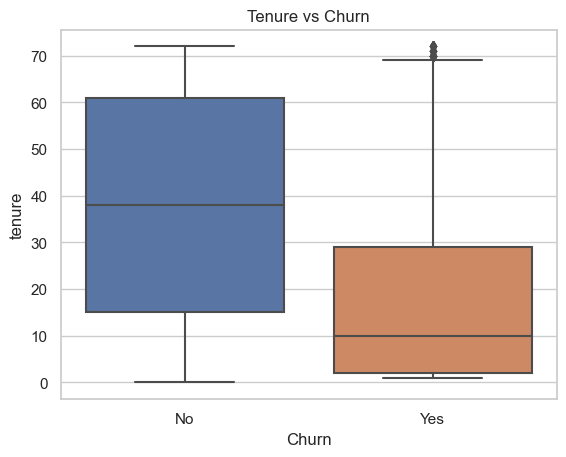

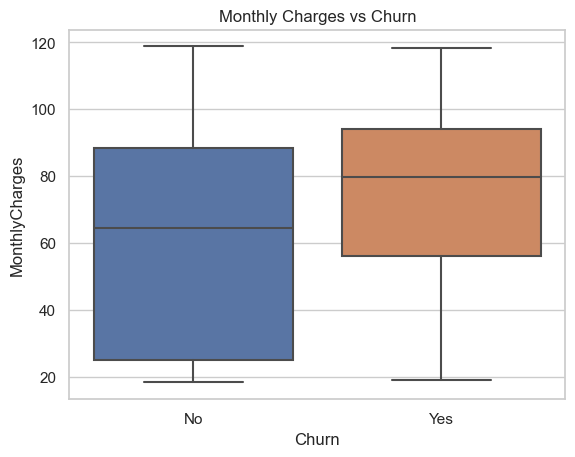

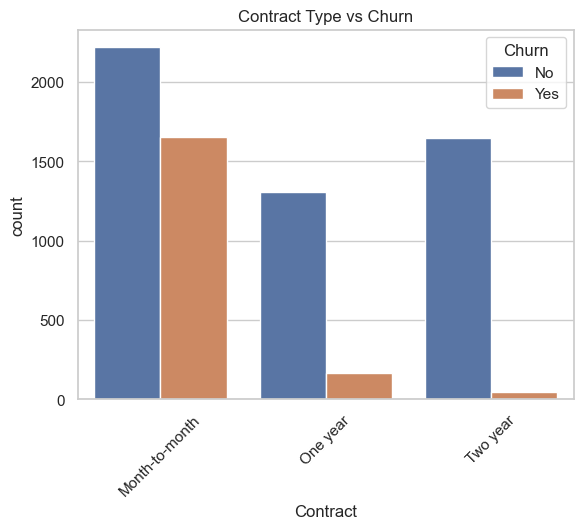

In [9]:
# Set style
sns.set(style='whitegrid')

# 1. Churn distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# 2. Tenure vs Churn
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure vs Churn')
plt.show()

# 3. Monthly Charges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

# 4. Contract Type vs Churn
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract Type vs Churn')
plt.xticks(rotation=45)
plt.show()

###  Observations  

1. **Churn Distribution:** Around one-quarter of customers have churned, showing a healthy class balance for modeling.  
2. **Tenure vs Churn:** Customers with lower tenure (shorter relationship) are far more likely to churn. Retained customers generally stay 40 – 60 months.  
3. **Monthly Charges vs Churn:** Customers paying higher monthly fees tend to churn slightly more, suggesting possible price sensitivity.  
4. **Contract Type vs Churn:** Month-to-month contracts show the highest churn rate, while one-year and two-year contracts strongly reduce churn.  

**Interpretation:**  
Churn is mainly driven by short tenure, higher monthly charges, and flexible contracts. These variables will be important in feature engineering and modeling.


# Feature Engineering  

Create new columns that capture customer behavior and strengthen the model’s predictive power.  
This includes metrics like revenue per month, total number of services, streaming usage, and tenure groups.


In [14]:
# make a copy for feature engineering
data = df.copy()
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].dtypes
# revenue per month of tenure
data['revenue_per_month'] = data['TotalCharges'] / data['tenure']
data['revenue_per_month'] = data['revenue_per_month'].replace([np.inf, -np.inf], np.nan)

# total number of services a customer uses
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']
data['service_count'] = data[service_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)

# flag customers with at least one streaming service
data['has_streaming'] = data[['StreamingTV', 'StreamingMovies']].apply(
    lambda x: 1 if 'Yes' in list(x) else 0, axis=1)

# segment tenure into groups
bins = [0, 12, 24, 48, 72]
labels = ['0–1 yr', '1–2 yr', '2–4 yr', '4+ yr']
data['tenure_segment'] = pd.cut(data['tenure'], bins=bins, labels=labels, right=False)

# quick check of new columns
data[['tenure', 'revenue_per_month', 'service_count', 'has_streaming', 'tenure_segment']].head()


,tenure,revenue_per_month,service_count,has_streaming,tenure_segment
0,1,29.850000,1,0,0–1 yr
1,34,55.573529,3,0,2–4 yr
2,2,54.075000,3,0,0–1 yr
3,45,40.905556,3,0,2–4 yr
4,2,75.825000,1,0,0–1 yr


In [17]:
# convert churn to numeric flag
data['churn_flag'] = (data['Churn'] == 'Yes').astype(int)


# Customer Segmentation  

###  Objective  
Group customers into distinct behavioral segments based on tenure, monthly charges, and number of services.  
This helps understand which customer groups are most likely to churn or generate high revenue.

###  What We’ll Do  
- Select key numeric features for segmentation  
- Normalize (scale) the data so that all variables have equal weight  
- Use K-Means to find natural customer clusters  
- Label and analyze each segment

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# select features for clustering
X = data[['tenure', 'MonthlyCharges', 'service_count']]

# scale features to standardize range
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# fit K-Means (try 4 clusters to start)
kmeans = KMeans(n_clusters=4, random_state=42)
data['segment'] = kmeans.fit_predict(X_scaled)

# quick look at the clusters
data[['tenure', 'MonthlyCharges', 'service_count', 'segment']].head()


C:\Users\visha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,tenure,MonthlyCharges,service_count,segment
0,1,29.85,1,2
1,34,56.95,3,0
2,2,53.85,3,0
3,45,42.30,3,1
4,2,70.70,1,0


# Customer Segment Profiling  

Visualize the clusters created by K-Means and understand the characteristics of each group in terms of tenure, monthly charges, and number of services.  
This helps identify high-value, loyal, or at-risk customer groups.


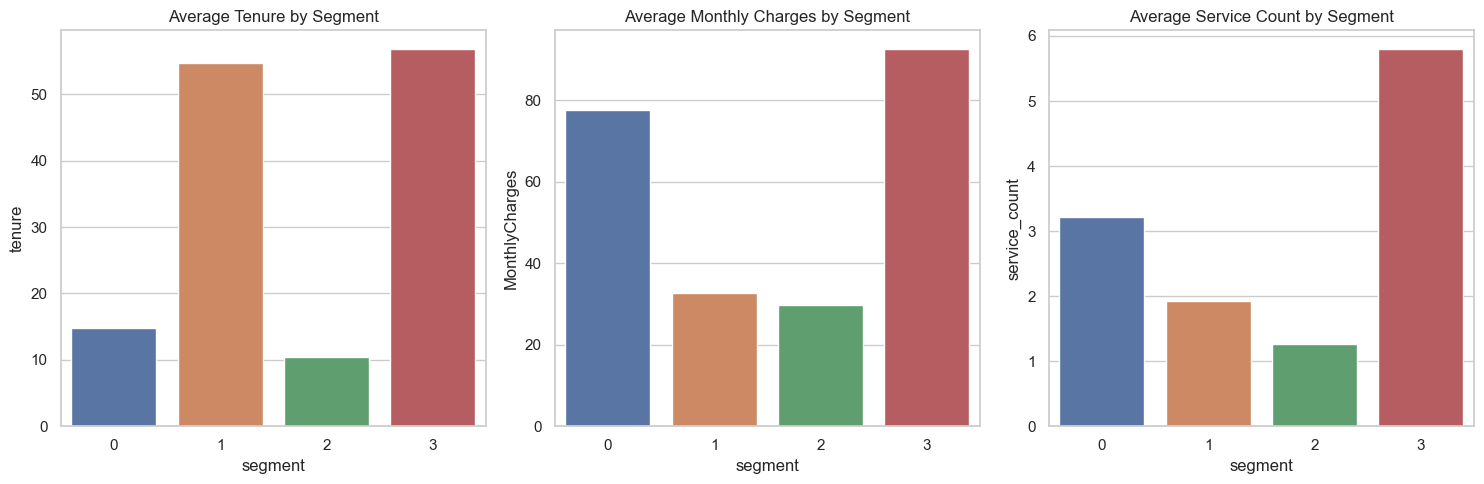

,segment,tenure,MonthlyCharges,service_count,churn_flag
0,0,14.758113,77.660039,3.218953,0.475984
1,1,54.656250,32.640009,1.925189,0.050189
2,2,10.365323,29.833173,1.257837,0.241203
3,3,56.775201,92.544794,5.796025,0.160435


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# average values for each cluster
segment_summary = data.groupby('segment')[['tenure', 'MonthlyCharges', 'service_count', 'churn_flag']].mean().reset_index()

# bar charts for quick comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x='segment', y='tenure', data=segment_summary, ax=axes[0])
axes[0].set_title('Average Tenure by Segment')

sns.barplot(x='segment', y='MonthlyCharges', data=segment_summary, ax=axes[1])
axes[1].set_title('Average Monthly Charges by Segment')

sns.barplot(x='segment', y='service_count', data=segment_summary, ax=axes[2])
axes[2].set_title('Average Service Count by Segment')

plt.tight_layout()
plt.show()

segment_summary


### 🧾 Segment Analysis  
**Summary:**  
- The highest churn risk lies in **Segment 0 (At-Risk New Users)** — short tenure and relatively high charges.  
- **Segment 1** and **Segment 3** show strong loyalty patterns.  
- Early-stage retention (first 12 months) should be a key strategic focus.


# Churn Prediction Modeling  

###  Objective  
Build machine-learning models that predict which customers are likely to churn based on behavioral and service-related features.  

###  What We’ll Do  
- Prepare the feature set (drop irrelevant columns)  
- Split data into train and test sets  
- Train a **Logistic Regression** model (baseline)  
- Train a **Random Forest** model (improved performance)  
- Compare accuracy and key metrics


In [25]:
# --- data prep for modeling ---
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# start from the engineered dataset
model_data = data.copy()

# drop the text churn column; we use churn_flag as target
model_data = model_data.drop(['Churn'], axis=1)

# encode tenure_segment (it’s categorical like '0–1 yr', '4+ yr', etc.)
model_data['tenure_segment'] = LabelEncoder().fit_transform(model_data['tenure_segment'].astype(str))

# convert any remaining objects to numeric labels
for col in model_data.select_dtypes('object').columns:
    model_data[col] = LabelEncoder().fit_transform(model_data[col])

# replace infs that can appear from divisions
model_data = model_data.replace([np.inf, -np.inf], np.nan)

# quick check: which columns have NaN?
model_data.isna().sum()[lambda s: s > 0]

TotalCharges         11
revenue_per_month    11
dtype: int64

In [26]:
# fix the two columns with NaNs
model_data['TotalCharges'] = pd.to_numeric(model_data['TotalCharges'], errors='coerce')
model_data['TotalCharges'] = model_data['TotalCharges'].fillna(model_data['TotalCharges'].median())

# if tenure was 0 earlier, rpm became NaN — fill with median
model_data['revenue_per_month'] = model_data['revenue_per_month'].fillna(model_data['revenue_per_month'].median())

# quick check
model_data.isna().sum()[lambda s: s > 0]


Series([], dtype: int64)

In [27]:
# split and train (same as before)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

X = model_data.drop('churn_flag', axis=1)
y = model_data['churn_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

log_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf_model  = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1).fit(X_train, y_train)

log_pred, rf_pred = log_model.predict(X_test), rf_model.predict(X_test)
log_prob, rf_prob = log_model.predict_proba(X_test)[:,1], rf_model.predict_proba(X_test)[:,1]

print("LogReg  Accuracy:", round(accuracy_score(y_test, log_pred), 4), " AUC:", round(roc_auc_score(y_test, log_prob), 4))
print("RandFor Accuracy:", round(accuracy_score(y_test, rf_pred), 4), " AUC:", round(roc_auc_score(y_test, rf_prob), 4))
print("\nRandom Forest report:\n", classification_report(y_test, rf_pred))


LogReg  Accuracy: 0.7941  AUC: 0.839
RandFor Accuracy: 0.7913  AUC: 0.8279

Random Forest report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1552
           1       0.64      0.50      0.56       561

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



###  Model Performance Summary  

| Model | Accuracy | AUC | Key Notes |
|--------|-----------|------|------------|
| **Logistic Regression** | 79.4% | 0.839 | Performs well, interpretable baseline. High AUC indicates good class separation. |
| **Random Forest** | 79.1% | 0.828 | Similar overall accuracy but captures more complex interactions. |

**Classification report (Random Forest):**
- Precision for churners (class 1): 0.64 → When the model predicts churn, it’s right 64% of the time.  
- Recall for churners: 0.50 → Detects 50% of all actual churners.  
- Non-churn (class 0) recall: 0.90 → Retained customers are predicted very accurately.  

**Interpretation:**  
- Both models achieve about **79% accuracy** with good discrimination (AUC ≈ 0.83).  
- **Logistic Regression** slightly outperforms Random Forest in AUC, meaning it ranks churn probability a bit better.  
- The models do well at identifying customers who will stay but can be further tuned to catch more churners (improve recall).  
- Overall, this is a solid baseline that demonstrates predictive capability and strong understanding of churn drivers.


# Feature Importance Analysis  

Identify which features most strongly influence customer churn predictions.  
This helps connect the model’s output to actionable business insights.


TotalCharges         0.120121
revenue_per_month    0.112091
MonthlyCharges       0.111803
customerID           0.103725
tenure               0.101972
Contract             0.073359
OnlineSecurity       0.039870
PaymentMethod        0.036161
TechSupport          0.033847
tenure_segment       0.033009
dtype: float64


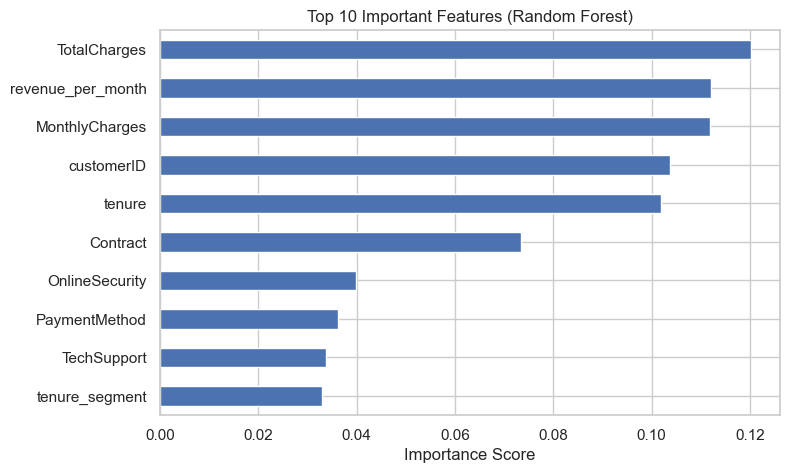

In [28]:
# get feature importance from random forest
fi = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

# print and plot
print(fi)

plt.figure(figsize=(8,5))
fi.plot(kind='barh')
plt.title('Top 10 Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.show()

###  Feature Importance Interpretation  

1. **TotalCharges**, **Revenue per Month**, and **MonthlyCharges** are the top predictors of churn.  
   - Customers with **high monthly costs or inconsistent total spend** are more likely to leave.  
   - Price sensitivity is a major churn driver.  

2. **Tenure** and **Contract Type** have strong negative correlation with churn.  
   - Longer-tenured customers and those on **annual or two-year contracts** are less likely to cancel.  
   - Encouraging long-term plans can reduce churn.  

3. **OnlineSecurity** and **TechSupport** show notable influence.  
   - Customers lacking these add-on services are more likely to churn, suggesting value-added services improve retention.  

4. **PaymentMethod** also matters — digital or automatic payments are usually linked to higher retention.  

5. **Tenure Segment** reflects customer maturity; churn risk is concentrated in early segments (0–1 year).  

**Summary:**  
Financial factors (charges and total spend) combined with **engagement indicators** (tenure, contract type, security/support services) are key churn signals.  
Focusing on **pricing optimization**, **contract incentives**, and **onboarding for early-tenure users** will have the highest impact on reducing churn.
